In [1]:
im_tort os 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Working with one file

In [2]:
keys_df = pd.read_csv('data/files/5_keystrokes.txt', sep='\t')

Notes:

$PT_t$ -> Press Time at timestep t\
$RT_t$ -> Release Time at timestamp t

* In paper they used four latency features:
* * Hold Latency                      
* * Inter-key Latency
* * Press Latency
* * Release Latency

$$
HL = RT_t - PT_t \\
IL = PT_t - RT_{t-1} \\
PL = PT_t - PT_{t-1} \\
RL = RT_t - RT_{t-1}
$$

So for a sequence with timestamp T we will collect t-1 latency features

In [3]:
pd.set_option('mode.chained_assignment', None)

section_ids = keys_df['TEST_SECTION_ID'].unique().tolist()
keys_df_example = keys_df[keys_df['TEST_SECTION_ID'] == section_ids[0]]

keys_df_example['PRESS_TIME_lag'] = keys_df_example['PRESS_TIME'].shift(1)
keys_df_example['PRESS_TIME_lag'] = np.where(keys_df_example['PRESS_TIME_lag'].isna(), keys_df_example['PRESS_TIME'], keys_df_example['PRESS_TIME_lag'])

keys_df_example['RELEASE_TIME_lag'] = keys_df_example['RELEASE_TIME'].shift(1)
keys_df_example['RELEASE_TIME_lag'] = np.where(keys_df_example['RELEASE_TIME_lag'].isna(), keys_df_example['RELEASE_TIME'], keys_df_example['RELEASE_TIME_lag'])

keys_df_example['PRESS_TIME_lag'] = keys_df_example['PRESS_TIME_lag'].astype('int64')
keys_df_example['RELEASE_TIME_lag'] = keys_df_example['RELEASE_TIME_lag'].astype('int64')

In [4]:
keys_df_example['HL'] =  keys_df_example['RELEASE_TIME'] - keys_df_example['PRESS_TIME']
keys_df_example['IL'] = keys_df_example['PRESS_TIME'] - keys_df_example['RELEASE_TIME_lag']
keys_df_example['PL'] = keys_df_example['PRESS_TIME'] - keys_df_example['PRESS_TIME_lag']
keys_df_example['RL'] = keys_df_example['RELEASE_TIME'] - keys_df_example['RELEASE_TIME_lag']

In [6]:
from preprocessing_utils import extract_latency_features_from_df as p

In [7]:
test_case = keys_df[keys_df['TEST_SECTION_ID'] == section_ids[1]]

In [8]:
output = p(test_case,
 'PRESS_TIME',
 'RELEASE_TIME',
 'KEYCODE',
 'PARTICIPANT_ID',
 'TEST_SECTION_ID')

In [9]:
(len(output['keycode_ids']),
len(output['hl']),
len(output['il']),
len(output['pl']),
len(output['rl']) )

(47, 47, 47, 47, 47)

### Extracting features from entire dataset & saving in one format

In [10]:
def find_bad_data(df):
    if any(df.isna().sum().drop('LETTER') > 0):
        return 1
    else:
        return 0
    
    
def frac_of_keycode_nan(df):
    tot = df.shape[0]
    nan_num = df.KEYCODE.isna().sum()
    if tot == 0:
        return 0.0
    return nan_num/tot

def check_stuff(df):
    output = dict(
        is_bad = find_bad_data(df),
        frac_nan_kc = frac_of_keycode(nan(df))    )

In [11]:
meta_df = pd.read_csv('data/metadata_participants.txt', sep='\t')
meta_df = meta_df[meta_df['LAYOUT'] =='qwerty']
meta_df = meta_df[meta_df['KEYBOARD_TYPE'].isin(['full', 'laptop'])]


ids_of_interest = meta_df['PARTICIPANT_ID'].tolist()

In [12]:
# reading all of the files, that are were typed in qwerty and on laptop/pc
keystrokes_data_files = [f'{i}_keystrokes.txt' for i in ids_of_interest]
keystrokes_real_files = os.listdir('data/files/')

keystrokes_data_files = sorted(list(set(keystrokes_data_files).intersection(set(keystrokes_real_files))))

In [13]:
from tqdm import tqdm
dataframes = []
failed_files = []
for path in tqdm(keystrokes_data_files):
    data_path = os.path.join(os.getcwd(), fr'data/files/{path}')
    try:
        df = pd.read_csv(data_path, sep='\t')
        for id in sorted(df.TEST_SECTION_ID.unique()):
            curr_df = df[df.TEST_SECTION_ID == id]
            dataframes.append(curr_df)
    except:
        failed_files.append(data_path)


len(failed_files)

100%|██████████| 162056/162056 [26:30<00:00, 101.90it/s] 


6048

In [14]:
final_dataset = pd.DataFrame()
final_dataset['frames'] = dataframes 

In [15]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
final_dataset['is_bad'] = final_dataset.frames.parallel_apply(find_bad_data)
final_dataset['keycode_nan_frac'] = final_dataset.frames.parallel_apply(frac_of_keycode_nan)

In [17]:
final_dataset = final_dataset[final_dataset['is_bad'] == 0]

In [18]:
print(f'{100 - final_dataset.shape[0]/len(dataframes) * 100 :.3f}% datapoints lostlost ')
print(f'{final_dataset.shape[0]} keystrokes in final dataset')

0.011% datapoints lostlost 
2339211 keystrokes in final dataset


In [19]:
features_df = final_dataset.parallel_apply(lambda x: p(x.frames,
                                                        'PRESS_TIME',
                                                        'RELEASE_TIME',
                                                        'KEYCODE',
                                                        'PARTICIPANT_ID',
                                                        'TEST_SECTION_ID'),
                                            axis='columns',
                                            result_type='expand')

In [20]:
features_df['participant_id'] = features_df['participant_id'].astype('int64')

In [30]:
trash_ids = features_df.groupby('participant_id').count().section_id[features_df.groupby('participant_id').count().section_id < 15].index.values
len(trash_ids)

260

In [33]:
features_df.groupby('participant_id').count()

,section_id,keycode_ids,hl,il,pl,rl
participant_id,,,,,,
5,15,15,15,15,15,15
23,15,15,15,15,15,15
24,15,15,15,15,15,15
25,15,15,15,15,15,15
30,15,15,15,15,15,15
...,...,...,...,...,...,...
517932,15,15,15,15,15,15
517936,15,15,15,15,15,15
517943,15,15,15,15,15,15


In [32]:
features_df_full = features_df[~features_df.participant_id.isin(trash_ids)]


,participant_id,section_id,keycode_ids,hl,il,pl,rl
0,100001,1090979,"[16, 87, 65, 83, 32, 87, 79, 78, 68, 69, 82, 7...","[151, 120, 144, 144, 136, 128, 200, 136, 64, 1...","[-151, -80, 56, -72, -32, 48, -24, -64, -8, 80...","[0, 71, 176, 72, 112, 184, 104, 136, 128, 144,...","[0, 40, 200, 72, 104, 176, 176, 72, 56, 240, 4..."
1,100001,1091001,"[16, 80, 76, 69, 65, 83, 69, 32, 71, 73, 86, 6...","[136, 160, 160, 152, 112, 168, 136, 104, 128, ...","[-136, -104, -48, -80, -8, -16, -48, -8, -8, -...","[0, 32, 112, 80, 144, 96, 120, 128, 96, 120, 1...","[0, 56, 112, 72, 104, 152, 88, 96, 120, 136, 1..."
2,100001,1091016,"[16, 77, 73, 67, 72, 65, 69, 76, 32, 83, 65, 7...","[112, 144, 127, 136, 120, 128, 184, 168, 96, 1...","[-112, -56, -55, -56, -24, -8, -64, -72, -64, ...","[0, 56, 89, 71, 112, 112, 64, 112, 104, 112, 9...","[0, 88, 72, 80, 96, 120, 120, 96, 32, 184, 56,..."
3,100001,1091025,"[16, 80, 85, 66, 76, 73, 67, 32, 79, 82, 68, 6...","[136, 136, 120, 112, 144, 152, 120, 112, 152, ...","[-136, -72, -24, 96, -16, -88, -32, -16, -8, -...","[0, 64, 112, 216, 96, 56, 120, 104, 104, 88, 1...","[0, 64, 96, 208, 128, 64, 88, 96, 144, 112, 72..."
4,100001,1091042,"[16, 84, 72, 69, 32, 76, 69, 84, 84, 69, 82, 8...","[120, 128, 120, 128, 144, 144, 120, 80, 120, 1...","[-120, -80, -8, -40, -40, -16, -72, -40, 112, ...","[0, 40, 120, 80, 88, 128, 72, 80, 192, 168, 88...","[0, 48, 112, 88, 104, 128, 48, 40, 232, 168, 1..."
...,...,...,...,...,...,...,...
2339456,99998,1091261,"[16, 16, 73, 32, 72, 65, 86, 69, 32, 70, 79, 8...","[337, 352, 80, 128, 81, 143, 112, 97, 112, 112...","[-337, 32, -80, 64, 47, 96, -32, 80, 47, 400, ...","[0, 369, 272, 144, 175, 177, 111, 192, 144, 51...","[0, 384, 0, 192, 128, 239, 80, 177, 159, 512, ..."
2339457,99998,1091290,"[16, 78, 69, 87, 32, 83, 87, 73, 84, 67, 72, 6...","[336, 64, 95, 96, 80, 64, 63, 80, 80, 79, 80, ...","[-336, -96, 193, 48, 64, 593, 144, 176, 400, 8...","[0, 240, 257, 143, 160, 673, 208, 239, 480, 91...","[0, -32, 288, 144, 144, 657, 207, 256, 480, 91..."
2339458,99998,1091319,"[16, 80, 82, 79, 66, 65, 66, 76, 89, 32, 67, 6...","[349, 64, 64, 64, 64, 112, 80, 80, 80, 112, 80...","[-349, -80, 240, 112, 752, 160, 48, 448, 208, ...","[0, 269, 304, 176, 816, 224, 160, 528, 288, 11...","[0, -16, 304, 176, 816, 272, 128, 528, 288, 14..."
2339459,99998,1091342,"[16, 68, 79, 32, 89, 79, 85, 32, 87, 65, 78, 8...","[577, 112, 95, 128, 96, 79, 96, 79, 64, 64, 96...","[-577, -48, 96, 64, 48, 1, 144, 81, 608, 144, ...","[0, 529, 208, 159, 176, 97, 223, 177, 687, 208...","[0, 64, 191, 192, 144, 80, 240, 160, 672, 208,..."


In [50]:
num_participants = features_df_full.participant_id.nunique()
print(f'{num_participants} unique ids')
num_of_train_samples = num_participants//2
num_of_test_samples = num_participants - num_of_train_samples
print(f'{num_of_train_samples} in train\n{num_of_test_samples} in test')

155747 unique ids
77873 in train
77874 in test


In [66]:
train_ids = features_df_full.drop_duplicates(subset=['participant_id']).participant_id.sample(num_of_train_samples, random_state=42).values
test_ids = features_df_full[~features_df_full.participant_id.isin(train_ids)].drop_duplicates(subset=['participant_id']).participant_id.values

In [70]:
print(len(train_ids))
print(len(test_ids))
print(len(train_ids) + (len(test_ids)))

77873
77874
155747


In [72]:
set(train_ids).intersection(set(test_ids))

set()

In [73]:
train_features_df_full = features_df_full[features_df_full.participant_id.isin(train_ids)]
test_features_df_full = features_df_full[features_df_full.participant_id.isin(test_ids)]

In [74]:
print(train_features_df_full.shape[0])
print(test_features_df_full.shape[0])

1168095
1168110


### Saving dataset in huggingface

In [77]:
from datasets import Dataset, DatasetDict

In [78]:
train_ds = Dataset.from_pandas(train_features_df_full)
test_ds = Dataset.from_pandas(test_features_df_full)

In [79]:
train_ds = train_ds.remove_columns('__index_level_0__')
test_ds = test_ds.remove_columns('__index_level_0__')

In [81]:
ds = DatasetDict({"train":train_ds,"test":test_ds})

In [82]:
ds

DatasetDict({
    train: Dataset({
        features: ['participant_id', 'section_id', 'keycode_ids', 'hl', 'il', 'pl', 'rl'],
        num_rows: 1168095
    })
    test: Dataset({
        features: ['participant_id', 'section_id', 'keycode_ids', 'hl', 'il', 'pl', 'rl'],
        num_rows: 1168110
    })
})

In [83]:
import huggingface_hub

In [84]:
huggingface_hub.login()

In [85]:
ds.push_to_hub('rokset3/136Mkeystrokes_features')

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
final_dataset_concat = pd.concat(final_dataset.frames.tolist())

In [87]:
final_dataset_concat

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE
0,100001.0,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891207.0,1.473275e+12,1.473275e+12,SHIFT,16.0
1,100001.0,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891214.0,1.473275e+12,1.473275e+12,W,87.0
2,100001.0,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891219.0,1.473275e+12,1.473275e+12,a,65.0
3,100001.0,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891226.0,1.473275e+12,1.473275e+12,s,83.0
4,100001.0,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891231.0,1.473275e+12,1.473275e+12,,32.0
...,...,...,...,...,...,...,...,...,...
655,99998.0,1091363,I'm not close enough right now to the discussion.,I'm not close enough right now to the discussion.,51911078.0,1.473276e+12,1.473276e+12,s,83.0
656,99998.0,1091363,I'm not close enough right now to the discussion.,I'm not close enough right now to the discussion.,51911083.0,1.473276e+12,1.473276e+12,i,73.0
657,99998.0,1091363,I'm not close enough right now to the discussion.,I'm not close enough right now to the discussion.,51911089.0,1.473276e+12,1.473276e+12,o,79.0
658,99998.0,1091363,I'm not close enough right now to the discussion.,I'm not close enough right now to the discussion.,51911095.0,1.473276e+12,1.473276e+12,n,78.0


In [88]:
final_dataset_concat.PRESS_TIME = final_dataset_concat.PRESS_TIME.astype('int64')
final_dataset_concat.RELEASE_TIME = final_dataset_concat.RELEASE_TIME.astype('int64')
final_dataset_concat.KEYSTROKE_ID = final_dataset_concat.KEYSTROKE_ID.astype('int64')
final_dataset_concat.PARTICIPANT_ID = final_dataset_concat.PARTICIPANT_ID.astype(int)

In [89]:
concat_ds = Dataset.from_pandas(final_dataset_concat)
concat_ds = concat_ds.remove_columns('__index_level_0__')

In [93]:
final_dataset_concat.isna().sum()

PARTICIPANT_ID            0
TEST_SECTION_ID           0
SENTENCE                  0
USER_INPUT                0
KEYSTROKE_ID              0
PRESS_TIME                0
RELEASE_TIME              0
LETTER             11268118
KEYCODE                   0
dtype: int64

In [90]:
concat_ds.push_to_hub('rokset3/136Mkeystrokes')

Pushing dataset shards to the dataset hub:   0%|          | 0/36 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3159 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Updating downloaded metadata with the new split.


# Dataset Preprocessing

## Experiment procedures 
retrieved from https://arxiv.org/pdf/2101.05570.pdf

* input_seq.shape = [seq_len, 5]
* keycode_normalized = keycode/255
* timing features converted to seconds


#### Dataset procedures
* take 68k first subjects
* evaluate on remaining 100k subjects
* no overlap between subjects

# My experimental procedure:
After dataset filtering and loading i have
* unique ids in train split: 77873
* unique ids in test split: 77874
* overall ids in both splits: 155747

----
### Preprocessing steps:



$$
keycode = \frac{keycode}{255} \\
HL_s = \frac{HL_{ms}}{1000} \\
IL_s = \frac{IL_{ms}}{1000}
PL_s = \frac{PL_{ms}}{1000}
RL_s = \frac{RL_{ms}}{1000}
$$


In [112]:
def preprocessing_fnct(example):
    example['keycode_ids'] = (np.array(example['keycode_ids'])/255).tolist()
    example['hl'] = (np.array(example['hl'])/1000).tolist()
    example['il'] = (np.array(example['il'])/1000).tolist()
    example['pl'] = (np.array(example['pl'])/1000).tolist()
    example['rl'] = (np.array(example['rl'])/1000).tolist()
    return example

In [123]:
train_ds_normalized = train_ds.map(preprocessing_fnct, batched=False, num_proc=24)
test_ds_normalized = test_ds.map(preprocessing_fnct, batched=False, num_proc=24)

Map (num_proc=24):   0%|          | 0/1168095 [00:00<?, ? examples/s]

Map (num_proc=24):   0%|          | 0/1168110 [00:00<?, ? examples/s]

# Exploraloty Data Analysis

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def calculate_mean_std(df: pd.DataFrame,
                       col_name:str,
                       normalize_by:int):
        flattened_list = np.concatenate(df[f'{col_name}'].values)/normalize_by
        
        return flattened_list.mean(), flattened_list.std()

In [173]:
features_df_full.columns

Index(['participant_id', 'section_id', 'keycode_ids', 'hl', 'il', 'pl', 'rl'], dtype='object')

In [174]:
keycode_mean, keycode_std = calculate_mean_std(features_df_full, 'keycode_ids', 255)
hl_mean, hl_std = calculate_mean_std(features_df_full, 'hl', 1000)
il_mean, il_std = calculate_mean_std(features_df_full, 'il', 1000)
pl_mean, pl_std = calculate_mean_std(features_df_full, 'pl', 1000)
rl_mean, rl_std = calculate_mean_std(features_df_full, 'rl', 1000)

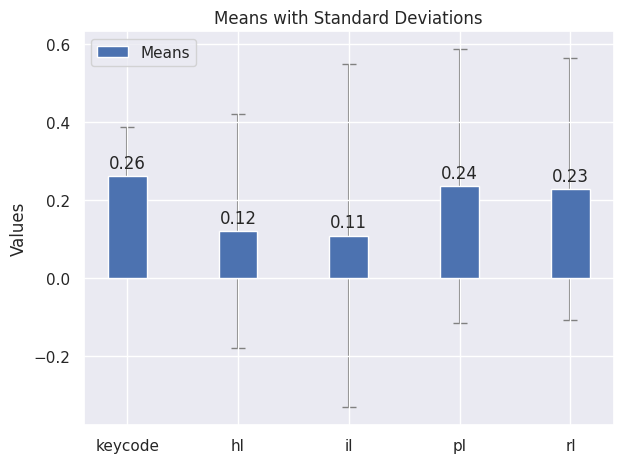

In [192]:
labels = ['keycode', 'hl', 'il', 'pl', 'rl']
means = [keycode_mean, hl_mean, il_mean, pl_mean, rl_mean]
std_devs = [keycode_std, hl_std, il_std, pl_std, rl_std]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()

# Create the bars
rects = ax.bar(x, means, width, label='Means')

# Add error bars behind the bars
ax.errorbar(x, means, yerr=std_devs, fmt='none', color='gray', capsize=5, zorder=-1)

ax.set_ylabel('Values')
ax.set_title('Means with Standard Deviations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.show()

### Distributions

In [194]:
def flatten_data(df: pd.DataFrame,
                 col_name:str,
                 normalize_by:int):
        flattened_list = np.concatenate(df[f'{col_name}'].values)/normalize_by
        
        return flattened_list

In [195]:
keycode_flattened = flatten_data(features_df_full, 'keycode_ids', 255)
hl_flattened = flatten_data(features_df_full, 'hl', 1000)
il_flattened = flatten_data(features_df_full, 'il', 1000)
pl_flattened = flatten_data(features_df_full, 'pl', 1000)
rl_flattened = flatten_data(features_df_full, 'rl', 1000)

Text(0.5, 1.0, 'Distribution of keycodes normalized')

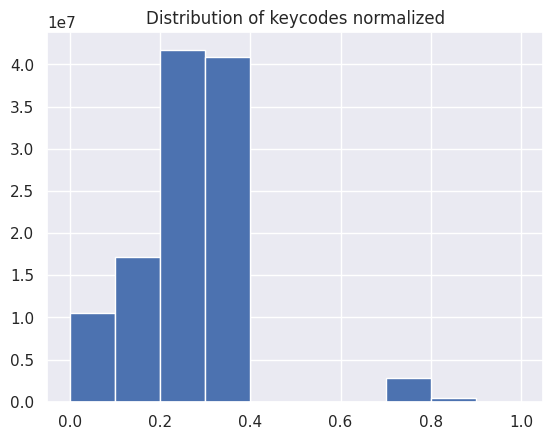

In [207]:
plt.hist(keycode_flattened)
plt.title('Distribution of keycodes normalized')

Text(0.5, 1.0, 'Distribution of HL normalized')

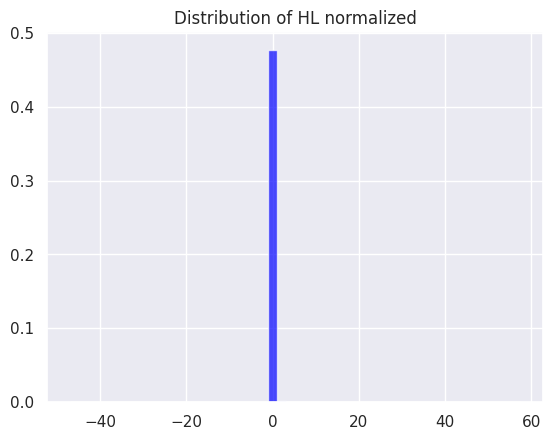

In [214]:
plt.hist(hl_flattened, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of HL normalized')

Text(0.5, 1.0, 'Distribution of IL normalized')

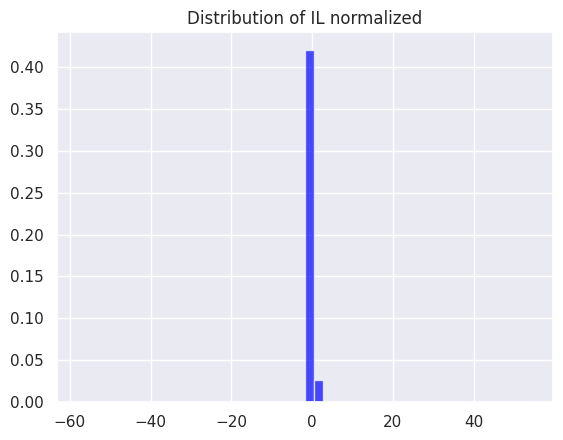

In [215]:
plt.hist(il_flattened, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of IL normalized')

Text(0.5, 1.0, 'Distribution of PL normalized')

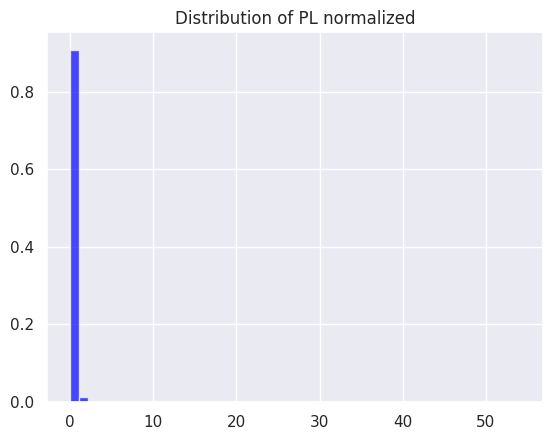

In [216]:
plt.hist(pl_flattened, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of PL normalized')

Text(0.5, 1.0, 'Distribution of RL normalized')

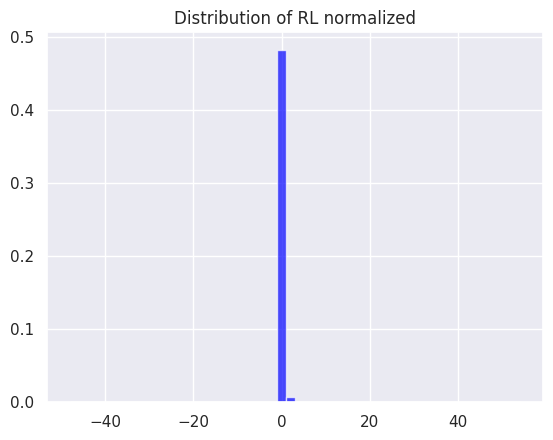

In [217]:
plt.hist(rl_flattened, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of RL normalized')

### Distributions of outliers

In [231]:
def get_outliers(arr, val):
    mask = np.where(arr> val, True, False)
    return arr[mask]
    

Text(0.5, 1.0, 'Distribution of HL outliers normalized')

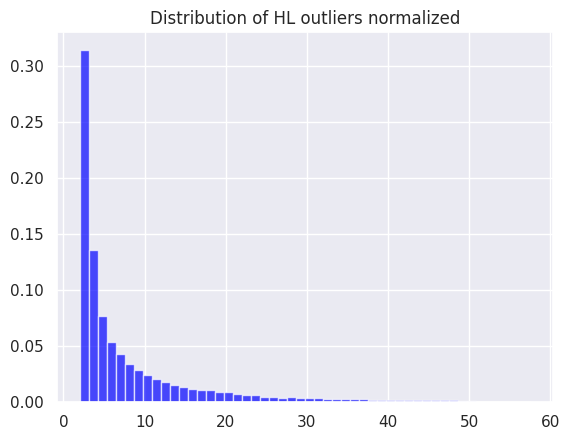

In [233]:
arr = get_outliers(hl_flattened, 2)
plt.hist(arr, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of HL outliers normalized')

Text(0.5, 1.0, 'Distribution of IL outliers normalized')

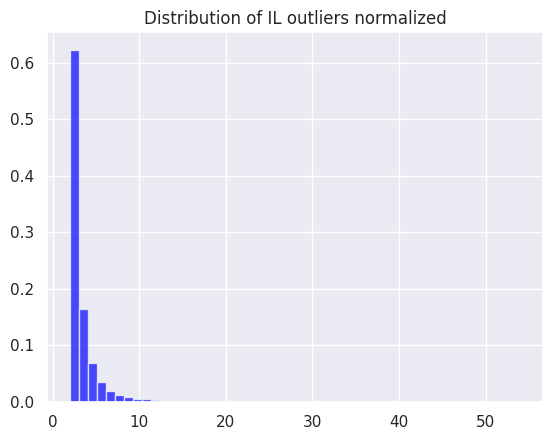

In [236]:
arr = get_outliers(il_flattened, 2)
plt.hist(arr, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of IL outliers normalized')

Text(0.5, 1.0, 'Distribution of PL outliers normalized')

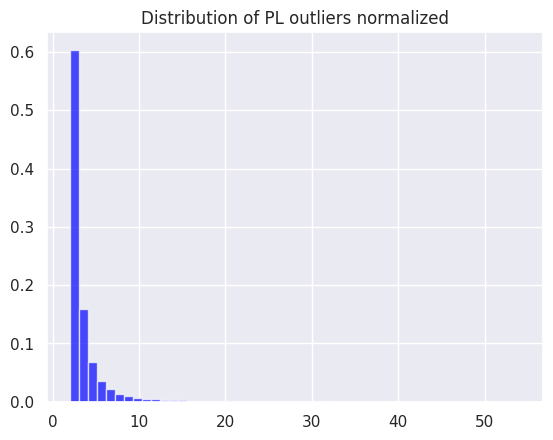

In [235]:
arr = get_outliers(pl_flattened, 2)
plt.hist(arr, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of PL outliers normalized')

Text(0.5, 1.0, 'Distribution of RL outliers normalized')

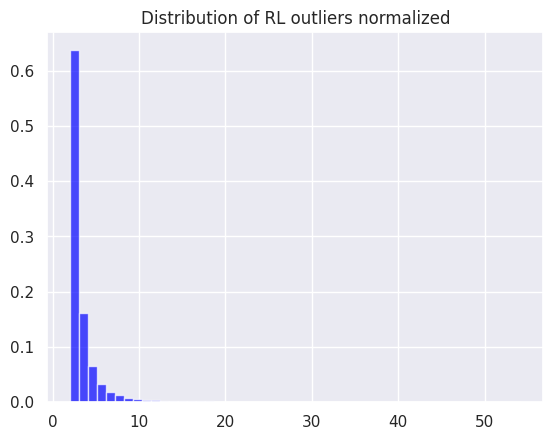

In [237]:
arr = get_outliers(rl_flattened, 2)
plt.hist(arr, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of RL outliers normalized')

### Average sequence_len

In [244]:
features_df_full['seq_len'] = features_df_full.keycode_ids.parallel_apply(len)

(array([1.369037e+06, 9.555140e+05, 1.144200e+04, 1.730000e+02,
        2.400000e+01, 1.200000e+01, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  1. ,  51.1, 101.2, 151.3, 201.4, 251.5, 301.6, 351.7, 401.8,
        451.9, 502. ]),
 <BarContainer object of 10 artists>)

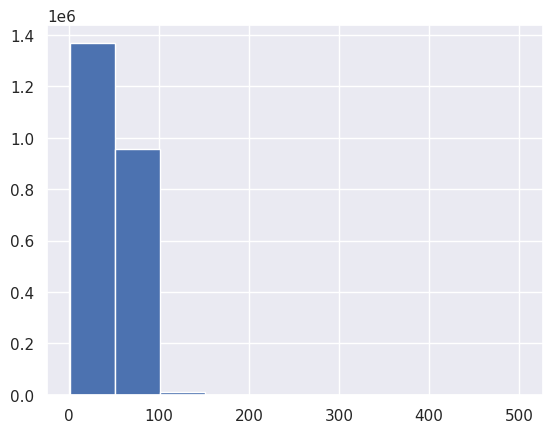

In [246]:
plt.hist(features_df_full.seq_len.values)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa237da5610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa237da5b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa237da5370>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa237dc50d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa237dc5370>],
 'means': []}

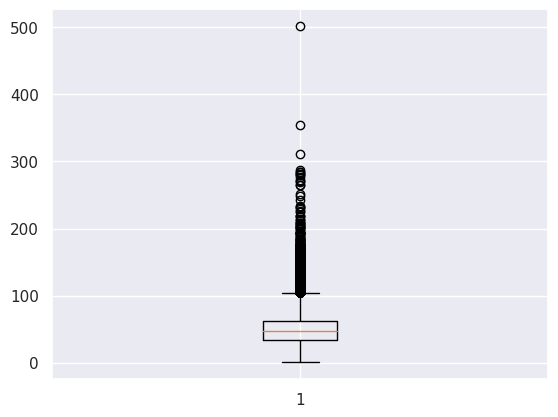

In [248]:
plt.boxplot(features_df_full.seq_len.values)

##### What are these outliers?

In [257]:
section_outlier_ids = features_df_full[features_df_full.seq_len > 100].section_id.values
participant_outlier_ids = features_df_full[features_df_full.seq_len > 100].participant_id.values

### Loading normalized dataset to huggingface

In [259]:
outlier_dfs = []
outlier_paths = []
for idx in participant_outlier_ids:
    outlier_paths.append(f'{idx}_keystrokes.txt')
    
for path in tqdm(outlier_paths):
    data_path = os.path.join(os.getcwd(), fr'data/files/{path}')
    df = pd.read_csv(data_path, sep='\t')
    for id in sorted(df.TEST_SECTION_ID.unique()):
        curr_df = df[df.TEST_SECTION_ID == id]
        outlier_dfs.append(curr_df)

100%|██████████| 12928/12928 [01:37<00:00, 132.46it/s]


In [276]:
outlier_pandas = pd.concat(outlier_dfs)
outlier_pandas = outlier_pandas[outlier_pandas.TEST_SECTION_ID.isin(section_outlier_ids)]

In [277]:
outlier_pandas_nodup = outlier_pandas.drop_duplicates(subset=['TEST_SECTION_ID'], keep='first')

In [286]:
print(f"{outlier_pandas[outlier_pandas.KEYCODE == 8].shape[0]/outlier_pandas.shape[0] * 100 :.2f} % of inputs contains BackSpace" )

18.76 % of inputs contains BackSpace


In [287]:
outlier_pandas.KEYCODE.value_counts()

KEYCODE
8      423885
32     256875
69     167910
84     120711
65     108120
        ...  
120         2
180         1
116         1
92          1
177         1
Name: count, Length: 107, dtype: int64

### Loading Normalized dataset to huggingface

In [288]:
ds_normalized = DatasetDict({"train":train_ds_normalized,"test":test_ds_normalized})

In [289]:
ds_normalized.push_to_hub('rokset3/keystrokes136M_normalized_features')

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/234 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]